In [1]:
import pandas as pd
import numpy as np

import glob
import re

from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
sns.set()

glob.glob('./input_data/2-pca_covid_demographic/*.csv')

['./input_data/2-pca_covid_demographic/covid_data_20211031.csv',
 './input_data/2-pca_covid_demographic/worldbank_demographic_data.csv',
 './input_data/2-pca_covid_demographic/a98d1d87-f256-432c-8124-5879c4053c51_Series - Metadata.csv']

# 1. COVID data

#### - Variables analyzed: cumulative deaths per 100k population for each country as of 2021-10-31.
#### - Source: data repository for the 2019 Novel Coronavirus Visual Dashboard  operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The data include the location and number of confirmed COVID-19 cases, deaths, and recoveries for all affected countries, aggregated at the appropriate province/state. Available at: https://console.cloud.google.com/marketplace/product/johnshopkins/covid19_jhu_global_case?project=gcloud-ed

In [2]:
COVID_INPUT = './input_data/2-pca_covid_demographic/covid_data_20211031.csv'
KEPT_COVID_VARS = ['country_name','deaths']
DROPPED_COUNTRIES = ['India', 'China']

# Read and filter covid data
covid_df = pd.read_csv(COVID_INPUT)
covid_df = covid_df[KEPT_COVID_VARS]
covid_df = covid_df[
    ~covid_df.country_name.isin(DROPPED_COUNTRIES)
]
covid_df.head()

,country_name,deaths
0,Afghanistan,7280
1,Albania,2924
2,Algeria,5920
3,Andorra,130
4,Angola,1710


In [3]:
def clean_country_name(n):
    return '_'.join(
        n.strip().split(' ')
    ).lower()

def clean_covid_data(_df):
    df = _df.copy(deep=True)
    
    df['country_name'] = df['country_name'].apply(clean_country_name)
    
    return df.dropna()

In [4]:
# Format country name and drop NA values
covid_df = clean_covid_data(_df=covid_df)
covid_df.head()

,country_name,deaths
0,afghanistan,7280
1,albania,2924
2,algeria,5920
3,andorra,130
4,angola,1710


## 2. Demographic data

#### - Variables analyzed: GDP per capita, % of population with access to sanitation, health investment per capita, total population and total urban population for each country.

#### - Source: World Bank DataBank - World Development Indicators. Available at: https://databank.worldbank.org/source/world-development-indicators#

In [5]:
DEMOG_INPUT = './input_data/2-pca_covid_demographic/worldbank_demographic_data.csv'
KEPT_DEMOG_VARS = [
    'NY.GDP.PCAP.CD',
    'SH.STA.SMSS.ZS',
    'SH.XPD.CHEX.PC.CD',
    'SP.POP.TOTL',
    'SP.URB.TOTL.IN.ZS'
]

# Read and filter demographic data
demog_df = pd.read_csv(DEMOG_INPUT)
demog_df = demog_df[
    demog_df['Series Code'].isin(KEPT_DEMOG_VARS)
]
demog_df.head()

,Country Name,Country Code,Series Name,Series Code,2019 [YR2019]
1,Afghanistan,AFG,Current health expenditure per capita (current...,SH.XPD.CHEX.PC.CD,65.80603027
3,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,494.179349886029
6,Afghanistan,AFG,Urban population (% of total population),SP.URB.TOTL.IN.ZS,25.754
9,Afghanistan,AFG,People using safely managed sanitation service...,SH.STA.SMSS.ZS,..
15,Afghanistan,AFG,"Population, total",SP.POP.TOTL,38041757


In [6]:
############################################################
# MAPPINGS FROM SERIES CODE TO SERIES NAME, DICT AND TABLE #
############################################################

# Dict
SERIES_MAP = {
    series['Series Code']: series['Series Name']
    for series in demog_df[
        ['Series Name', 'Series Code']
    ]\
    .drop_duplicates()\
    .dropna()\
    .to_dict(orient='records')
}

# Table
SERIES_TABLE = demog_df[
    ['Series Name', 'Series Code']
].drop_duplicates().dropna().sort_values(
    by='Series Code'
).reset_index(
    drop=True
)

In [7]:

def clean_demog_data(_df):

    df = _df.copy(deep=True)
    # Get statistic for each country
    df = df[
        ~df['2019 [YR2019]'].apply(lambda x: x=='..' or pd.isna(x))
    ][[
        'Country Name',
        'Series Name',
        'Series Code',
        '2019 [YR2019]'
    ]].pivot(
        index='Country Name',
        columns='Series Code',
        values='2019 [YR2019]'
    ).reset_index().rename(
        columns={'Country Name':'country_name'}
    )
    df.columns.name = None
    
    # Drop NA values
    df = df.dropna()

    # Format country name
    df['country_name'] = df['country_name'].apply(clean_country_name)
    
    # Cast to float
    for col in [c for c in df.columns if c != 'country_name']:
        df[col] = df[col].astype(float)
    
    return df.reset_index(drop=True)

In [8]:
# Transform table to having each row a country and each column a metric relative to a country
demog_df = clean_demog_data(_df=demog_df)
demog_df.head()

,country_name,NY.GDP.PCAP.CD,SH.STA.SMSS.ZS,SH.XPD.CHEX.PC.CD,SP.POP.TOTL,SP.URB.TOTL.IN.ZS
0,africa_western_and_central,1777.918672,24.231488,61.338476,446911598.0,47.242853
1,algeria,3989.668276,17.839063,248.205872,43053054.0,73.189000
2,andorra,40897.330873,100.000004,2744.194336,77146.0,87.984000
3,arab_world,6489.043216,49.538868,381.575981,427870273.0,59.201646
4,armenia,4604.646324,67.762796,523.999084,2957728.0,63.219000


# 3. Join COVID and Demographic data, perform PCA

In [9]:
# JOIN DEMOGRAPHIC DATA WITH COVID DATA
joined = pd.merge(
    covid_df,
    demog_df,
    on='country_name',
    how='inner'
)

# Create normalized variable
joined['deaths_per_100k_pop'] = 1E5*joined['deaths']/joined['SP.POP.TOTL']
joined = joined.drop(columns=['deaths'])

joined

,country_name,NY.GDP.PCAP.CD,SH.STA.SMSS.ZS,SH.XPD.CHEX.PC.CD,SP.POP.TOTL,SP.URB.TOTL.IN.ZS,deaths_per_100k_pop
0,algeria,3989.668276,17.839063,248.205872,43053054.0,73.189,13.750476
1,andorra,40897.330873,100.000004,2744.194336,77146.0,87.984,168.511653
2,armenia,4604.646324,67.762796,523.999084,2957728.0,63.219,213.948003
3,australia,54875.285956,73.292582,5427.462402,25365745.0,86.124,6.871472
4,austria,50114.401110,99.640766,5242.183105,8879920.0,58.515,127.895296
...,...,...,...,...,...,...,...
92,turkey,9121.515167,78.062272,396.466827,83429607.0,75.630,84.635422
93,ukraine,3661.456204,71.977338,248.133484,44386203.0,69.473,162.377034
94,united_arab_emirates,42701.443045,99.147700,1842.694458,9770526.0,86.789,21.861668
95,united_kingdom,43070.498360,98.081537,4312.889160,66836327.0,83.652,211.045409


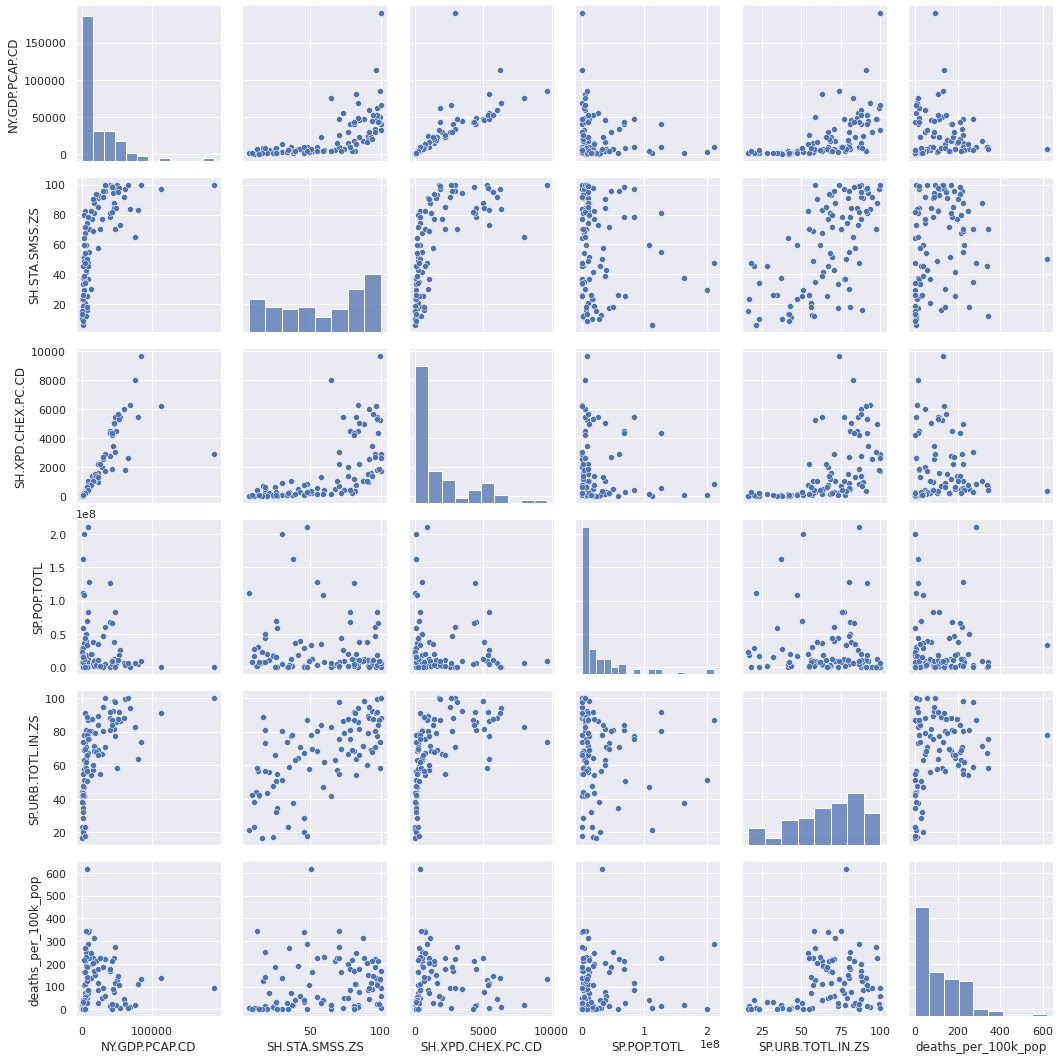

In [10]:
sns.pairplot(joined)

In [11]:
# Get Z-scores for variables
X=(joined-joined.mean())/np.sqrt(joined.var())

# Get eigenvalues for correlation matrix of X
pcs_vars, pcs = np.linalg.eigh(
    a=pd.DataFrame(X).corr()
)

# Transform eigenvectors from cols to rows
pcs = pcs.T

# Sort eigenvectors by eigenvalue size (desc)
pcs_vars, pcs = zip(
    *sorted(
        zip(pcs_vars, pcs),
        reverse=True
    )
)
pcs = np.array(pcs)

# Columns for printing
PRINT_COLS = [
    'pib_per_capita',
    'perc_acesso_saneamento',
    'invest_saude_per_capita',
    'populacao_total',
    'populacao_urbana_total',
#     'casos_por_100k_habit',
    'mortes_por_100k_habit'
]

print('-'*100)
print('Total variables in PCA analysis: {}'.format(X.corr().shape[0]))
print('-'*100)

----------------------------------------------------------------------------------------------------
Total variables in PCA analysis: 6
----------------------------------------------------------------------------------------------------


In [12]:
print('-'*100)
print('PCS VARIANCES (EIGENVALUES):\n{}'.format(
        pcs_vars
    )
)
print('-'*100)

----------------------------------------------------------------------------------------------------
PCS VARIANCES (EIGENVALUES):
(2.9754887179225786, 1.09966383348212, 0.9703108028044343, 0.42293185387277726, 0.3200092040706963, 0.21159558784739596)
----------------------------------------------------------------------------------------------------


In [13]:
print('-'*100)
print('CUMULATIVE VARIANCE EXPLAINED:\n{}'.format(
        np.cumsum(pcs_vars)/np.sum(pcs_vars)
    )
)
print('-'*100)

----------------------------------------------------------------------------------------------------
CUMULATIVE VARIANCE EXPLAINED:
[0.49591479 0.67919209 0.84091056 0.9113992  0.96473407 1.        ]
----------------------------------------------------------------------------------------------------


In [14]:
print('-'*100)
print('PRINCIPAL COMPONENTS:\n{}'.format(pcs))
print('-'*100)

----------------------------------------------------------------------------------------------------
PRINCIPAL COMPONENTS:
[[-0.5021513  -0.50256416 -0.49505257  0.11188723 -0.46852895 -0.1347522 ]
 [ 0.2653856  -0.09869566  0.23269969 -0.25489039 -0.23715194 -0.86282695]
 [ 0.07767642  0.01728691  0.15170934  0.95768101  0.03247259 -0.2290075 ]
 [-0.27067063  0.14210103 -0.45353749 -0.03206034  0.72783644 -0.41240115]
 [ 0.28596001 -0.84375003  0.1363665  -0.01713287  0.41836835  0.11131631]
 [ 0.71857165  0.07268268 -0.67339884  0.06354391 -0.13567295  0.04960875]]
----------------------------------------------------------------------------------------------------


In [15]:
# First PC
PC_NUMBER=1
pd.DataFrame(
    index=[0],
    data = dict(zip(PRINT_COLS,pcs[PC_NUMBER-1]))
)

,pib_per_capita,perc_acesso_saneamento,invest_saude_per_capita,populacao_total,populacao_urbana_total,mortes_por_100k_habit
0,-0.502151,-0.502564,-0.495053,0.111887,-0.468529,-0.134752


In [16]:
# Second PC
PC_NUMBER=2
pd.DataFrame(
    index=[0],
    data = dict(zip(PRINT_COLS,pcs[PC_NUMBER-1]))
)

,pib_per_capita,perc_acesso_saneamento,invest_saude_per_capita,populacao_total,populacao_urbana_total,mortes_por_100k_habit
0,0.265386,-0.098696,0.2327,-0.25489,-0.237152,-0.862827


In [18]:
# PROJECTION OF X ONTO PC BASIS
X_pc = np.matmul(X.drop(columns='country_name'), pcs.T)
X_pc.columns = ['pc_{}'.format(i+1) for i in range(pcs.shape[1])]

# Add variables for analysis
X_pc['country_name'] = joined['country_name']
X_pc['deaths_per_100k_pop'] = joined['deaths_per_100k_pop']

In [21]:
print('-'*100)
print('FIRST PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[0]))
        )
    ) 
)
print('-'*100)
print('SECOND PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[1]))
        )
    ) 
)
print('-'*100)

# Deaths per 100k pop
alt.Chart(X_pc).mark_circle(size=60).encode(
    x='pc_1',
    y='pc_2',
    color=alt.Color('deaths_per_100k_pop', scale=alt.Scale(scheme='magma')),
    tooltip=['country_name', 'deaths_per_100k_pop']
).properties(
    width=1200,
    height=900
).configure_view(
    strokeWidth=0
)

----------------------------------------------------------------------------------------------------
FIRST PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0       -0.502151               -0.502564                -0.495053   

   populacao_total  populacao_urbana_total  mortes_por_100k_habit  
0         0.111887               -0.468529              -0.134752  
----------------------------------------------------------------------------------------------------
SECOND PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0        0.265386               -0.098696                   0.2327   

   populacao_total  populacao_urbana_total  mortes_por_100k_habit  
0         -0.25489               -0.237152              -0.862827  
----------------------------------------------------------------------------------------------------


alt.Chart(...)

 - First PC: May be interpreted as an "underdevelopment score". A country will have a higher coordinate on this PC the lower its per capita GDP, % of access to proper sanitation, per capita health investment and urban population.
 - Second PC: May be interpreted as a "covid death response score". Dominated by deaths by 100k inhabitants, a country will also have higher scores on this PC if it has high GDP and health investment per capita or a low urban and total population.
 - "V-shaped" graph indicates that countries with the highest level of deaths per 100k inhabitants are those with intermediate development. Possible reasons are that lowly developed countries do not have as much urban agglomerations, are less integrated into the global economy or may have subnotification, while highly developed countries present the resources to better handle the health crisis. On the other hand, countries with intermediate development do 